In [1]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

from scipy.io import loadmat, savemat
from fracModel import fracOrdUU
import os
import numpy as np

0.23.0


In [2]:
matplotlib.use('Qt5Agg')

In [3]:
#Locations - Sahil
location_al = "D:\Documents\CS637 project\Original Dataset\data_set_IVa_al_mat\\100Hz\data_set_IVa_al.mat"

In [5]:
import scipy.io
mat = scipy.io.loadmat(location_al)

In [67]:
def get_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X)
    
    return fModel._AMat[-1]

In [7]:
sfreq = mat['nfo']['fs'][0][0][0][0]

EEGdata = mat['cnt'].T
EEGdata = 1e-1*EEGdata   #To convert to uV

nchannels, nsamples = EEGdata.shape

ch_names = [s[0] for s in mat['nfo']['clab'][0][0][0]]

event_onsets = mat['mrk'][0][0][0]
event_codes = mat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in mat['mrk']['className'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]

xpos = mat['nfo']['xpos'][0][0]
ypos = mat['nfo']['ypos'][0][0]

nclasses = len(cl_lab)
nevents = len(event_onsets.transpose())

In [8]:
trials = {}

win = np.arange(int(0*sfreq), int(3*sfreq))    # Epoch size of each trial (0 to 3 sec)
nsamples = len(win)

In [9]:
for cl, code in zip(cl_lab, np.unique(event_codes)):
    cl_onsets = event_onsets[event_codes == code]
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    for i, onset in enumerate(cl_onsets):
        trials[cl][:, :, i] = EEGdata[:, win+onset]

In [12]:
right = np.rollaxis(trials[cl1], 2, 0)
foot = np.rollaxis(trials[cl2], 2, 0)

In [13]:
data = np.concatenate([right, foot])

In [15]:
Y = np.concatenate([-np.ones(right.shape[0]), np.ones(foot.shape[0])])    # Labeling right as -1 and foot as 1

In [16]:
# Converting to BIDS using mne
n_channels = 118

info = mne.create_info(
ch_names = ch_names,
ch_types = ['eeg']*nchannels,
sfreq = sfreq)

layout_pos = np.concatenate([xpos, ypos], axis = 1)

layout = mne.channels.generate_2d_layout(
xy = layout_pos,
ch_names = ch_names,
name = "EEG custom layout")

In [17]:
event_id = dict(right = -1, foot = 1)

eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev, dtype = int),
                         np.zeros(eventLength, dtype = int),
                         np.array(Y, dtype = int)))

In [18]:
tmin = 0
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [ ]:
 epochs.plot()

In [22]:
final_ch_list = ["T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8"] #Channels which affect motor controls the most

In [23]:
edata = epochs.get_data(picks = final_ch_list)
edata.shape

(224, 9, 300)

In [24]:
edata[0]

array([[-45.9, -45.4, -45.6, ..., -74.8, -80.5, -82.8],
       [  6.8,   9. ,   8.2, ..., -18.1, -24.7, -26.2],
       [-27.7, -24.7, -23.9, ..., -63.5, -67.5, -68.7],
       ...,
       [  9.8,   2.9,   5.1, ..., -26.5, -23. , -21.4],
       [ 13.1,   2.8,   5.7, ...,   0.8,   6.5,   8.1],
       [-34.4, -47.7, -44.6, ..., -18.4, -13.5, -12.7]])

In [25]:
Y.shape

(224,)

In [28]:
Adata = np.stack([get_A(x) for x in edata])

beginning mse = 36.878589
iter ind = 0, mse = 7.911015
iter ind = 1, mse = 7.909732
iter ind = 2, mse = 7.908970
time taken = 8.500354
beginning mse = 28.616677
iter ind = 0, mse = 7.107843
iter ind = 1, mse = 7.104635
iter ind = 2, mse = 7.103508
time taken = 11.650610
beginning mse = 47.931486
iter ind = 0, mse = 7.805756
iter ind = 1, mse = 7.802993
iter ind = 2, mse = 7.802188
time taken = 9.272833
beginning mse = 37.300835
iter ind = 0, mse = 5.362429
iter ind = 1, mse = 5.359246
iter ind = 2, mse = 5.357780
time taken = 9.160011
beginning mse = 36.168489
iter ind = 0, mse = 5.320041
iter ind = 1, mse = 5.316874
iter ind = 2, mse = 5.315130
time taken = 11.039949
beginning mse = 40.127791
iter ind = 0, mse = 15.686388
iter ind = 1, mse = 15.685102
iter ind = 2, mse = 15.684367
time taken = 9.445356
beginning mse = 53.377658
iter ind = 0, mse = 12.545636
iter ind = 1, mse = 12.539805
iter ind = 2, mse = 12.538337
time taken = 10.888820
beginning mse = 46.681256
iter ind = 0, mse = 

In [88]:
# np.savez('Adata.npz', Adata = Adata, Y = Y)

#### Feature extraction

In [2]:
# Loading Data
Adata = np.load("Adata.npz")["Adata"]
Y = np.load("Adata.npz")["Y"]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
print(np.sum(Y<0)) #Checking number of "right" events

112


In [35]:
Adata.max()

33.733155957972485

In [21]:
ARight = np.average(Adata[0:112], axis = 0)
AFoot = np.average(Adata[112:], axis = 0)

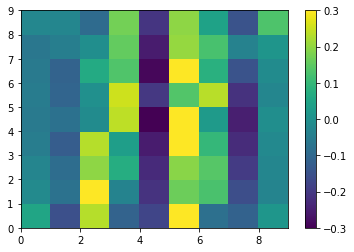

In [89]:
fig = plt.figure()
f = plt.pcolormesh(ARight, vmin=-0.3, vmax=0.3)
plt.colorbar(f)

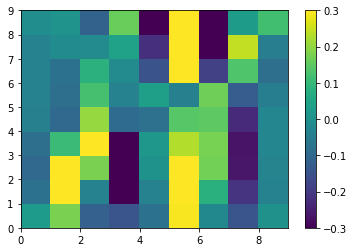

In [88]:
fig = plt.figure()
f = plt.pcolormesh(AFoot, vmin=-0.3, vmax=0.3)
plt.colorbar(f)

## Applying ML

In [53]:
X = np.stack([np.concatenate([a[:, 1], a[:, 3]]) for a in Adata])

In [54]:
X.shape

(224, 18)

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
y_pred = classifier.predict(X_test)

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[19  3]
 [ 1 22]]


In [59]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 89.90 %
Standard Deviation: 7.87 %


#### Kernal SVM

In [60]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [61]:
y_pred = classifier.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[19  3]
 [ 2 21]]


0.8888888888888888

#### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [64]:
y_pred = classifier.predict(X_test)

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[19  3]
 [ 2 21]]


0.8888888888888888